In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import preprocessing
import informe
from sklearn.metrics import plot_roc_curve, classification_report

sns.set()

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

# Preprocesamiento

In [3]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.ordinal_encode(X)
X = preprocessing.dummy_variables(X)
X = preprocessing.normalizar(X)
X = preprocessing.pca(X, n_components=4)

# SVM: entrenamiento y búsqueda de hiperparámetros.

### Cross validation

Se usa una baja proporción de datos para train para acelerar el entrenamiento de SVM.

In [4]:
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = preprocessing.dataset_split(pd.DataFrame(X), y, test_size = 0.40)
print(f'X_train tiene {len(X_train)} elementos')

X_train tiene 19536 elementos


Se usa GridSearch para buscar la mejor combinación de hiperparámetros. Se elige la mejor combinación según su score de la curva ROC-AUC. 

## Modelo 1: Kernel lineal

In [5]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='linear', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

gscv_lineal = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_lineal.best_params_

{'C': 10, 'gamma': 'scale'}

### Métricas


Resultados SVM con kernel lineal:
    Mejores hiperparámetros: {'C': 10, 'gamma': 'scale'}
    Métrica AUC ROC: 0.52
    Otras metricas:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      9888
           1       0.62      0.21      0.31      3137

    accuracy                           0.78     13025
   macro avg       0.71      0.58      0.59     13025
weighted avg       0.75      0.78      0.73     13025



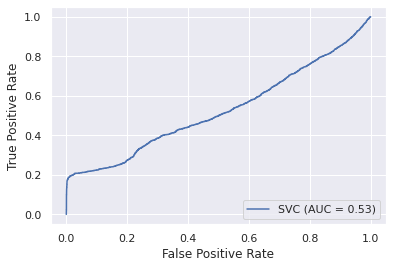

In [6]:
informe.imprimir_metricas(gscv_lineal, X_test, y_test, 'SVM con kernel lineal:')
roc = plot_roc_curve(gscv_lineal.best_estimator_, X_test, y_test)

## Modelo 2: Kernel polinomial

In [7]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='poly', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'degree': [2, 3]}

gscv_poly = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_poly.best_params_

KeyboardInterrupt: 

### Métricas


In [ ]:
informe.imprimir_metricas(gscv_poly, X_test, y_test, 'SVM con kernel polinomial:')
roc = plot_roc_curve(gscv_poly.best_estimator_, X_test, y_test)

## Modelo 3: Kernel radial

In [8]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='rbf', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

gscv_rbf = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_rbf.best_params_

{'C': 10, 'gamma': 'auto'}

### Métricas


In [ ]:
informe.imprimir_metricas(gscv_rbf, X_test, y_test, 'SVM con kernel radial:')
roc = plot_roc_curve(gscv_rbf.best_estimator_, X_test, y_test)

## Modelo 4: Kernel sigmoideo

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='sigmoid', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'] }

gscv_sig = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_sig.best_params_

### Métricas


In [ ]:
informe.imprimir_metricas(gscv_sig, X_test, y_test, 'SVM con kernel sigmoideo:')
roc = plot_roc_curve(gscv_sig.best_estimator_, X_test, y_test)

# Conclusión
      En base a la metrica AUC-ROC, se elige el modelo de SVM con kernel radial
      
### Informe del modelo usando los datos del test_holdout

In [ ]:
import sklearn

y_pred = gscv_rbf.predict(X_test)

informe.plt_distribucion_de_clases(y_test)
informe.plot_matriz_de_confusion(gscv_rbf, X_test, y_test)
roc = plot_roc_curve(gscv_rbf.best_estimator_, X_test, y_test)
print('Métricas:')
informe.imprimir_metricas(gscv_sig, X_test, y_test, 'SVM con kernel sigmoideo:')

# Final test

In [9]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.ordinal_encode(df_test)
df_test = preprocessing.dummy_variables(df_test)
df_test = preprocessing.normalizar(df_test)
df_test = preprocessing.pca(df_test, n_components=4)

y_pred = gscv_rbf.predict(df_test)
informe.save_pred(y_pred, 'svm')